In [2]:
from  skimage.io import imread, imshow
import pywt
import pywt.data
import matplotlib.pyplot as plt
import numpy as np
import glob
import gmm
from tqdm import tqdm
import json
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import dbscan

# Obtener datos procesados

## Obtener todas las imagenes

In [4]:
rutas_imagenes = glob.glob(f'./imagenes/*.png', recursive=True)
print(rutas_imagenes)

['./imagenes/S060_003_00000018.png', './imagenes/S147_002_00000011.png', './imagenes/S071_004_00000028.png', './imagenes/S042_004_00000019.png', './imagenes/S106_004_00000008.png', './imagenes/S148_002_00000014.png', './imagenes/S077_001_00000028.png', './imagenes/S501_004_00000056.png', './imagenes/S101_002_00000018.png', './imagenes/S131_006_00000022.png', './imagenes/S026_006_00000011.png', './imagenes/S085_003_00000011.png', './imagenes/S078_001_00000032.png', './imagenes/S116_001_00000013.png', './imagenes/S022_005_00000031.png', './imagenes/S119_008_00000018.png', './imagenes/S082_001_00000014.png', './imagenes/S137_005_00000027.png', './imagenes/S113_001_00000012.png', './imagenes/S077_006_00000013.png', './imagenes/S022_005_00000030.png', './imagenes/S061_004_00000021.png', './imagenes/S504_002_00000007.png', './imagenes/S155_002_00000011.png', './imagenes/S069_004_00000017.png', './imagenes/S083_003_00000017.png', './imagenes/S074_005_00000041.png', './imagenes/S127_010_000000

## Funcion para obtener caraccteristicos

In [5]:
def obtener_caracteristico(ruta: str, cortes: int=1) -> np.ndarray:
  imagen = imread(ruta)
  cA = imagen
  cH =  cV = cD = None
  for _ in range(cortes):
     cA, (cH, cV, cD) = pywt.dwt2(cA, 'haar')
  return cA

## Generar "matrices" caracteristicas

In [6]:
# lista de matrices con vectores caracteristicos obtenidos tras aplicar C cortes
caracteristicos = []

for cortes in range(5):
  temporal_caracteristicos = [] 
  for ruta_imagen in tqdm(rutas_imagenes):
    temporal_caracteristicos.append(obtener_caracteristico(ruta_imagen, cortes))
  caracteristicos.append(np.array(temporal_caracteristicos))

100%|██████████| 981/981 [00:00<00:00, 2296.43it/s]


# Guardar variables 
Comentado para no sobreescribir

## Guardar matrices en archivos

In [3]:
ruta_drive = './matrices_imagenes/'

for n_cortes in range(len(caracteristicos)):
  with open(ruta_drive+f'caracteristicos{n_cortes}.npy', 'wb') as f:
    np.save(f, caracteristicos[n_cortes])

## Guardar orden de rutas

In [11]:
with open(ruta_drive+'orden_rutas.json', 'w') as f:
  json.dump(rutas_imagenes, f)

# Leer archivos 
De las variables guardadas

## Leer rutas

In [12]:
rutas_imagenes = {}
with open(ruta_drive + 'orden_rutas.json', 'r') as f:
    rutas_imagenes = json.load(f) # Agregar la variable que tendrá el json

## Leer matrices caracteristicas

In [13]:
caracteristicos = []
for n_cortes in range(5):
  with open(ruta_drive + f'caracteristicos{n_cortes}.npy', 'rb') as f:
    caracteristicos.append(np.load(f)) # Agregar las variables donde se almacenarán

# Reducción de dimensiones

In [15]:
linearizar_caracteristicos = caracteristicos.copy()
for c in range(len(linearizar_caracteristicos)):
  linearizar_caracteristicos[c] = caracteristicos[c].reshape(caracteristicos[c].shape[0], caracteristicos[c].shape[1]*caracteristicos[c].shape[2])

 Obtener los vectores transformados quenos representan $r$ de representatividad de los datos totales

In [16]:
from sklearn.decomposition import PCA
pca = None
repr = [0.9, 0.95, 0.99]
for r in repr:
  for cortes in range(len(linearizar_caracteristicos)):
    for comps in range(1, min(linearizar_caracteristicos[cortes].shape[0], linearizar_caracteristicos[cortes].shape[1])):
      pca = PCA(n_components=comps, svd_solver='arpack').fit(linearizar_caracteristicos[cortes])
      if np.sum(pca.explained_variance_ratio_) > r:
        print(f'representatividad: {r}, cortes: {cortes}, componentes: {min(linearizar_caracteristicos[cortes].shape[0], linearizar_caracteristicos[cortes].shape[1])}, componentes_optimas: {comps}')
        with open(ruta_drive+f'caracteristicos{cortes}_pca{r}.npy', 'wb') as f:
          np.save(f, pca.transform(linearizar_caracteristicos[cortes]))
        break

representatividad: 0.9, cortes: 0, componentes: 981, componentes_optimas: 47
representatividad: 0.9, cortes: 1, componentes: 576, componentes_optimas: 32
representatividad: 0.9, cortes: 2, componentes: 144, componentes_optimas: 17
representatividad: 0.9, cortes: 3, componentes: 36, componentes_optimas: 7
representatividad: 0.9, cortes: 4, componentes: 9, componentes_optimas: 3
representatividad: 0.95, cortes: 0, componentes: 981, componentes_optimas: 91
representatividad: 0.95, cortes: 1, componentes: 576, componentes_optimas: 59
representatividad: 0.95, cortes: 2, componentes: 144, componentes_optimas: 30
representatividad: 0.95, cortes: 3, componentes: 36, componentes_optimas: 12
representatividad: 0.95, cortes: 4, componentes: 9, componentes_optimas: 5
representatividad: 0.99, cortes: 0, componentes: 981, componentes_optimas: 231
representatividad: 0.99, cortes: 1, componentes: 576, componentes_optimas: 150
representatividad: 0.99, cortes: 2, componentes: 144, componentes_optimas: 6

# Leer archivos PCA

In [4]:
rutas_pca = glob.glob(ruta_drive + "*.npy")
diccionario_pca = {}
for ruta in rutas_pca:
  if len(ruta.split('_')) > 1:
    diccionario_pca[os.path.splitext(os.path.basename(ruta))[0]] = np.load(ruta)

In [5]:
diccionario_pca.keys()

dict_keys(['caracteristicos0_pca0.9', 'caracteristicos4_pca0.99', 'caracteristicos3_pca0.95', 'caracteristicos1_pca0.99', 'caracteristicos0', 'caracteristicos2', 'caracteristicos3', 'caracteristicos1_pca0.9', 'caracteristicos2_pca0.99', 'caracteristicos4', 'caracteristicos1_pca0.95', 'caracteristicos3_pca0.99', 'caracteristicos0_pca0.95', 'caracteristicos1', 'caracteristicos4_pca0.95', 'caracteristicos2_pca0.9', 'caracteristicos0_pca0.99', 'caracteristicos4_pca0.9', 'caracteristicos2_pca0.95', 'caracteristicos3_pca0.9'])

In [46]:
emotion_folders = glob.glob('./CK+48/*/')
emotion_mapping = []
emotion_images = {}


for i in range(len(emotion_folders)):
    emotion_folder = emotion_folders[i]
    current_emotion = emotion_folder.split('/')[-2]
    emotion_mapping.append(current_emotion)

    for im in glob.glob(emotion_folder + '*'):
        emotion_images[im.split('/')[-1]] = i


print(emotion_images)
print(emotion_mapping)



{'S071_004_00000028.png': 0, 'S042_004_00000019.png': 0, 'S022_005_00000031.png': 0, 'S119_008_00000018.png': 0, 'S022_005_00000030.png': 0, 'S127_010_00000018.png': 0, 'S075_008_00000011.png': 0, 'S112_005_00000015.png': 0, 'S045_005_00000029.png': 0, 'S071_004_00000026.png': 0, 'S100_005_00000021.png': 0, 'S055_004_00000026.png': 0, 'S119_008_00000016.png': 0, 'S028_001_00000022.png': 0, 'S014_003_00000028.png': 0, 'S126_008_00000028.png': 0, 'S072_005_00000019.png': 0, 'S087_007_00000016.png': 0, 'S109_003_00000015.png': 0, 'S119_008_00000017.png': 0, 'S011_004_00000021.png': 0, 'S011_004_00000019.png': 0, 'S058_005_00000010.png': 0, 'S075_008_00000010.png': 0, 'S067_004_00000021.png': 0, 'S134_003_00000010.png': 0, 'S092_003_00000014.png': 0, 'S092_003_00000012.png': 0, 'S111_006_00000010.png': 0, 'S029_001_00000017.png': 0, 'S113_008_00000022.png': 0, 'S136_005_00000009.png': 0, 'S999_001_00000018.png': 0, 'S050_004_00000019.png': 0, 'S502_001_00000016.png': 0, 'S011_004_00000020.

In [54]:
rutas_pca = glob.glob('./imagenes/*.png' )


final_labels = []

print(rutas_pca)

for image_route in rutas_pca:
    image = image_route.split('/')[-1]
    # print(image)
    # print(emotion_mapping[emotion_images[image]])
    final_labels.append(emotion_images[image])
    # plt.imshow(plt.imread(image_route))
    # plt.show()
np.save('images_labels/labels_for_images',final_labels)
np.save('images_labels/mapping_for_label',np.array(emotion_mapping))

['./imagenes/S060_003_00000018.png', './imagenes/S147_002_00000011.png', './imagenes/S071_004_00000028.png', './imagenes/S042_004_00000019.png', './imagenes/S106_004_00000008.png', './imagenes/S148_002_00000014.png', './imagenes/S077_001_00000028.png', './imagenes/S501_004_00000056.png', './imagenes/S101_002_00000018.png', './imagenes/S131_006_00000022.png', './imagenes/S026_006_00000011.png', './imagenes/S085_003_00000011.png', './imagenes/S078_001_00000032.png', './imagenes/S116_001_00000013.png', './imagenes/S022_005_00000031.png', './imagenes/S119_008_00000018.png', './imagenes/S082_001_00000014.png', './imagenes/S137_005_00000027.png', './imagenes/S113_001_00000012.png', './imagenes/S077_006_00000013.png', './imagenes/S022_005_00000030.png', './imagenes/S061_004_00000021.png', './imagenes/S504_002_00000007.png', './imagenes/S155_002_00000011.png', './imagenes/S069_004_00000017.png', './imagenes/S083_003_00000017.png', './imagenes/S074_005_00000041.png', './imagenes/S127_010_000000

981
surprise


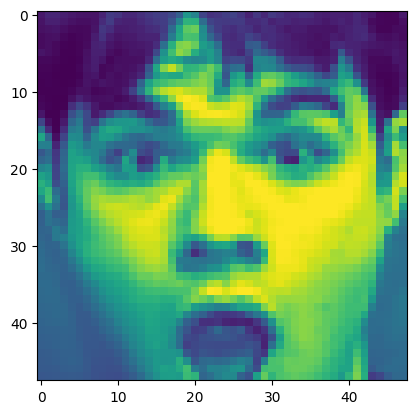

disgust


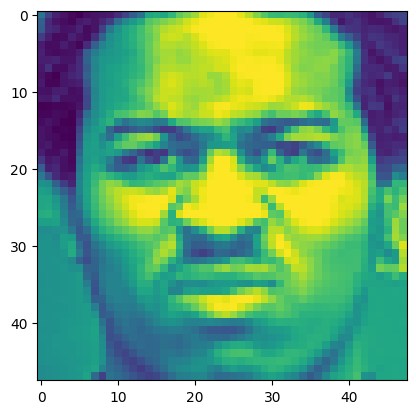

contempt


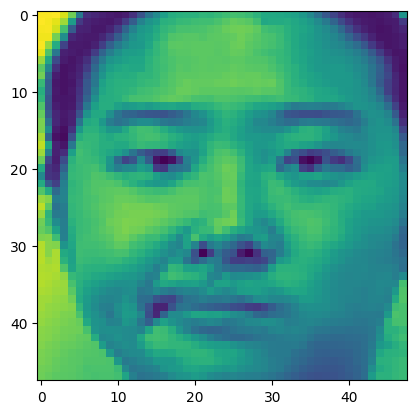

surprise


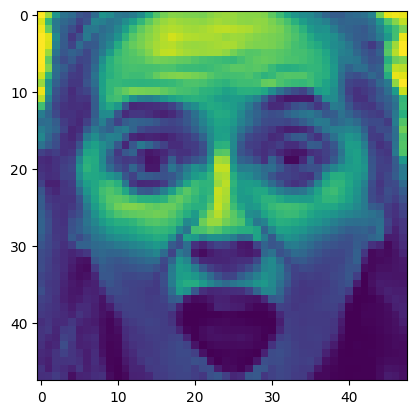

surprise


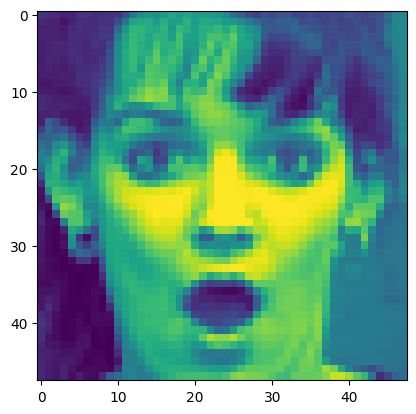

In [73]:
#loading labels
rutas_images = glob.glob('./imagenes/*.png' )
labels_for_images = np.load('images_labels/labels_for_images.npy')
mapping_for_label = np.load('images_labels/mapping_for_label.npy')

print(len(rutas_images))

for i in range(255,260):
    
    im = rutas_pca[i]
    image_name = im.split('/')[-1]

    print(mapping_for_label[labels_for_images[i]])
    plt.imshow(plt.imread(im))
    plt.show()